# Procedure
- Solving regression problem using Metropolis-Hastings algorithm with logistic regression.
  ![logistic regression](Exam_pass_logistic_curve.svg.png)

The sigmoid function shown above is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

# Import libraries


In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, bernoulli
from utils.myreports import report
from imblearn.over_sampling import SMOTE
from utils.mydata import load_data, data_to_numpy
from utils.betaplots import histograms_X, histograms, traces, autocorrelations
from utils.mynumpy import nearestPD, standard_normal_with_nans
import gc
from pathlib import Path

# function definitions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
# Define logistic log-likelihood
def logistic_log_likelihood(beta, X, y):
    logits = X @ beta
    return np.sum(y * logits - np.log(1 + np.exp(logits)))

# Define the prior for beta (normal prior)
def log_prior_beta(beta, mu=0, sigma=10):
    return np.sum(stats.norm.logpdf(beta, mu, sigma))

# Define the prior for X (multivariate normal prior)
def log_prior_X(X, mu, Sigma):
    #print(f"2: Sigma {Sigma}")
    return np.sum(stats.multivariate_normal.logpdf(X, mean=mu, cov=Sigma, allow_singular=True))

# Proposal distributions for beta
def proposal_beta(beta, scale):
    return np.random.normal(beta, scale, size=beta.shape)

# Proposal distribution for X
def proposal_X(X, mask, y, beta, mu, Sigma):
    X_proposal = X.copy()
    # Only propose new values for missing entries
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if mask[i, j]:
                mean_j = mu[j] + Sigma[j, :] @ np.linalg.inv(Sigma) @ (X_proposal[i, :] - mu)
                std_j = np.sqrt(Sigma[j, j] - Sigma[j, :] @ np.linalg.inv(Sigma) @ Sigma[:, j])
                X_proposal[i, j] = np.random.normal(mean_j, std_j)
                if y[i] == 1:
                    X_proposal[i, j] += np.random.normal(0, 1 / np.exp(X_proposal[i, :] @ beta))
                else:
                    X_proposal[i, j] -= np.random.normal(0, 1 / (1 + np.exp(X_proposal[i, :] @ beta)))
    return X_proposal

# Proposal distribution for X, no y observed
def proposal_X_no_y(X, mask, mu, Sigma):
    X_proposal = X.copy()
    # Only propose new values for missing entries
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if mask[i, j]:
                mean_j = mu[j] + Sigma[j, :] @ np.linalg.inv(Sigma) @ (X_proposal[i, :] - mu)
                std_j = np.sqrt(Sigma[j, j] - Sigma[j, :] @ np.linalg.inv(Sigma) @ Sigma[:, j])
                X_proposal[i, j] = np.random.normal(mean_j, std_j)
    return X_proposal

def test_model(X_test, samples):
    #X_imputed = impute_missing_values_test(X_test, samples)
    beta_mean = samples.mean(axis=0)
    y_pred_prob = sigmoid(X_test @ beta_mean)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    return y_pred, y_pred_prob

# Metropolis-Hastings sampler


In [8]:
def mh_sampler(X, y, burn:int, iter_tot:int, scale_beta, scale_x):
    # Get a mask of NaN values
    #X_no_intercept=X[:,1:]
    mask = np.isnan(X)
    # Impute initial values for missing data
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_imputed = imputer.fit_transform(X)

    # Calculate initial values for mu and Sigma from filtered data
    mu_X = np.mean(X_imputed, axis=0)
    Sigma_X = np.cov(X_imputed, rowvar=False)
    #matrix[0, 0] = 1
    Sigma_X = nearestPD(A=Sigma_X)
    #print(f"1 Sigma_X {Sigma_X}")

    # Run MH sampler with priors and missing value imputation
    initial_beta = np.zeros(X.shape[1])
    beta_samples = [initial_beta]
    X_samples = [X.copy()]
    
    current_beta = initial_beta
    current_X = X_imputed
    current_log_post = logistic_log_likelihood(current_beta, current_X, y) + log_prior_beta(current_beta) + log_prior_X(current_X, mu_X, Sigma_X)
    accept_count = 0
    print(f"scale beta {scale_beta}")
    print(f"scale x {scale_x}")
    
    
    for iter in range(iter_tot):
        # Propose new beta
        proposed_beta = proposal_beta(current_beta, scale=scale_beta)
        # Propose new X for missing values
        proposed_X = proposal_X(current_X, mask, y, current_beta, mu_X, Sigma_X*scale_x)
        proposed_log_post = logistic_log_likelihood(proposed_beta, proposed_X, y) + log_prior_beta(proposed_beta) + log_prior_X(proposed_X, mu_X, Sigma_X)        
        acceptance_ratio = np.exp(proposed_log_post - current_log_post)
        
        if np.random.rand() < acceptance_ratio:
            current_beta = proposed_beta
            current_X = proposed_X
            current_log_post = proposed_log_post
            accept_count += 1

        if iter > burn:
            beta_samples.append(current_beta)
            if iter % 100 == 0:  # Reduce the frequency of saving X_samples to reduce memory usage
                X_samples.append(current_X.copy())
                gc.collect()  # Explicitly free memory
        print(f"iter {iter} beta {current_beta}")
    
    return np.array(beta_samples), np.array(X_samples), accept_count / (iter_tot)

# Main Function

In [9]:
# Main Function
def main(file_path, burn:int, iter_tot:int, scale_beta:float, scale_x:float):
    data = load_data(file_path)
    X, y, col_names = data_to_numpy(data)
    print(f"before {X.shape}")
    histograms_X(X=X, col_names=col_names)
    X = standard_normal_with_nans(X)
    ones_column = np.ones((X.shape[0], 1))
    X = np.hstack((ones_column, X))
    col_names = ["Intercept"]+ col_names
    #print(col_names)
    histograms_X(X=X, col_names=col_names)

    #print(f"after    {X.shape}")

    # train and test split, oversampling for train   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train = np.where(np.isnan(X_train), -1234567, X_train)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    # oversample because there is 1/10 bankruptcies
    X_train = np.where(X_train == -1234567, np.nan, X_train)
    # sample beta and X
    samples_beta, samples_X , acceptance_rate= mh_sampler(X=X_train, y=y_train, burn=burn, 
                                                          iter_tot=iter_tot, 
                                                          scale_beta=scale_beta,
                                                         scale_x=scale_x)
    traces(samples_beta=samples_beta, col_names=col_names)
    histograms(samples_beta=samples_beta, col_names=col_names)
    autocorrelations(samples_beta=samples_beta, col_names=col_names)
    #y_pred, y_pred_prob = test_model(X_test, samples)

    # Print results
    print(f"Acceptance Rate: {acceptance_rate}")
    #print(f"after {samples_X.shape}")
    X_imputed_train = samples_X.reshape(-1,samples_X.shape[-1])
    histograms_X(X=X_imputed_train, col_names=col_names)

    # run prediction for the test set
    # assume distribution in train and test to be the same, so use mu and sigma from learned imputed X_train
    mask = np.isnan(X_test)
    mu_X_imputed_train = np.mean(X_imputed_train, axis=0)
    Sigma_X_imputed_train = np.cov(X_imputed_train, rowvar=False)
    X_test = proposal_X_no_y(X_test, mask, mu_X_imputed_train, Sigma_X_imputed_train)
    y_pred, y_pred_prob = test_model(X_test, samples_beta)
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy}")

    report(true=y_test, pred=y_pred)



before (7649, 12)


/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/Dropbox/Hanken/2024Linz/Bayes/coursework/utils/betaplots.py:58: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(q10, q90)


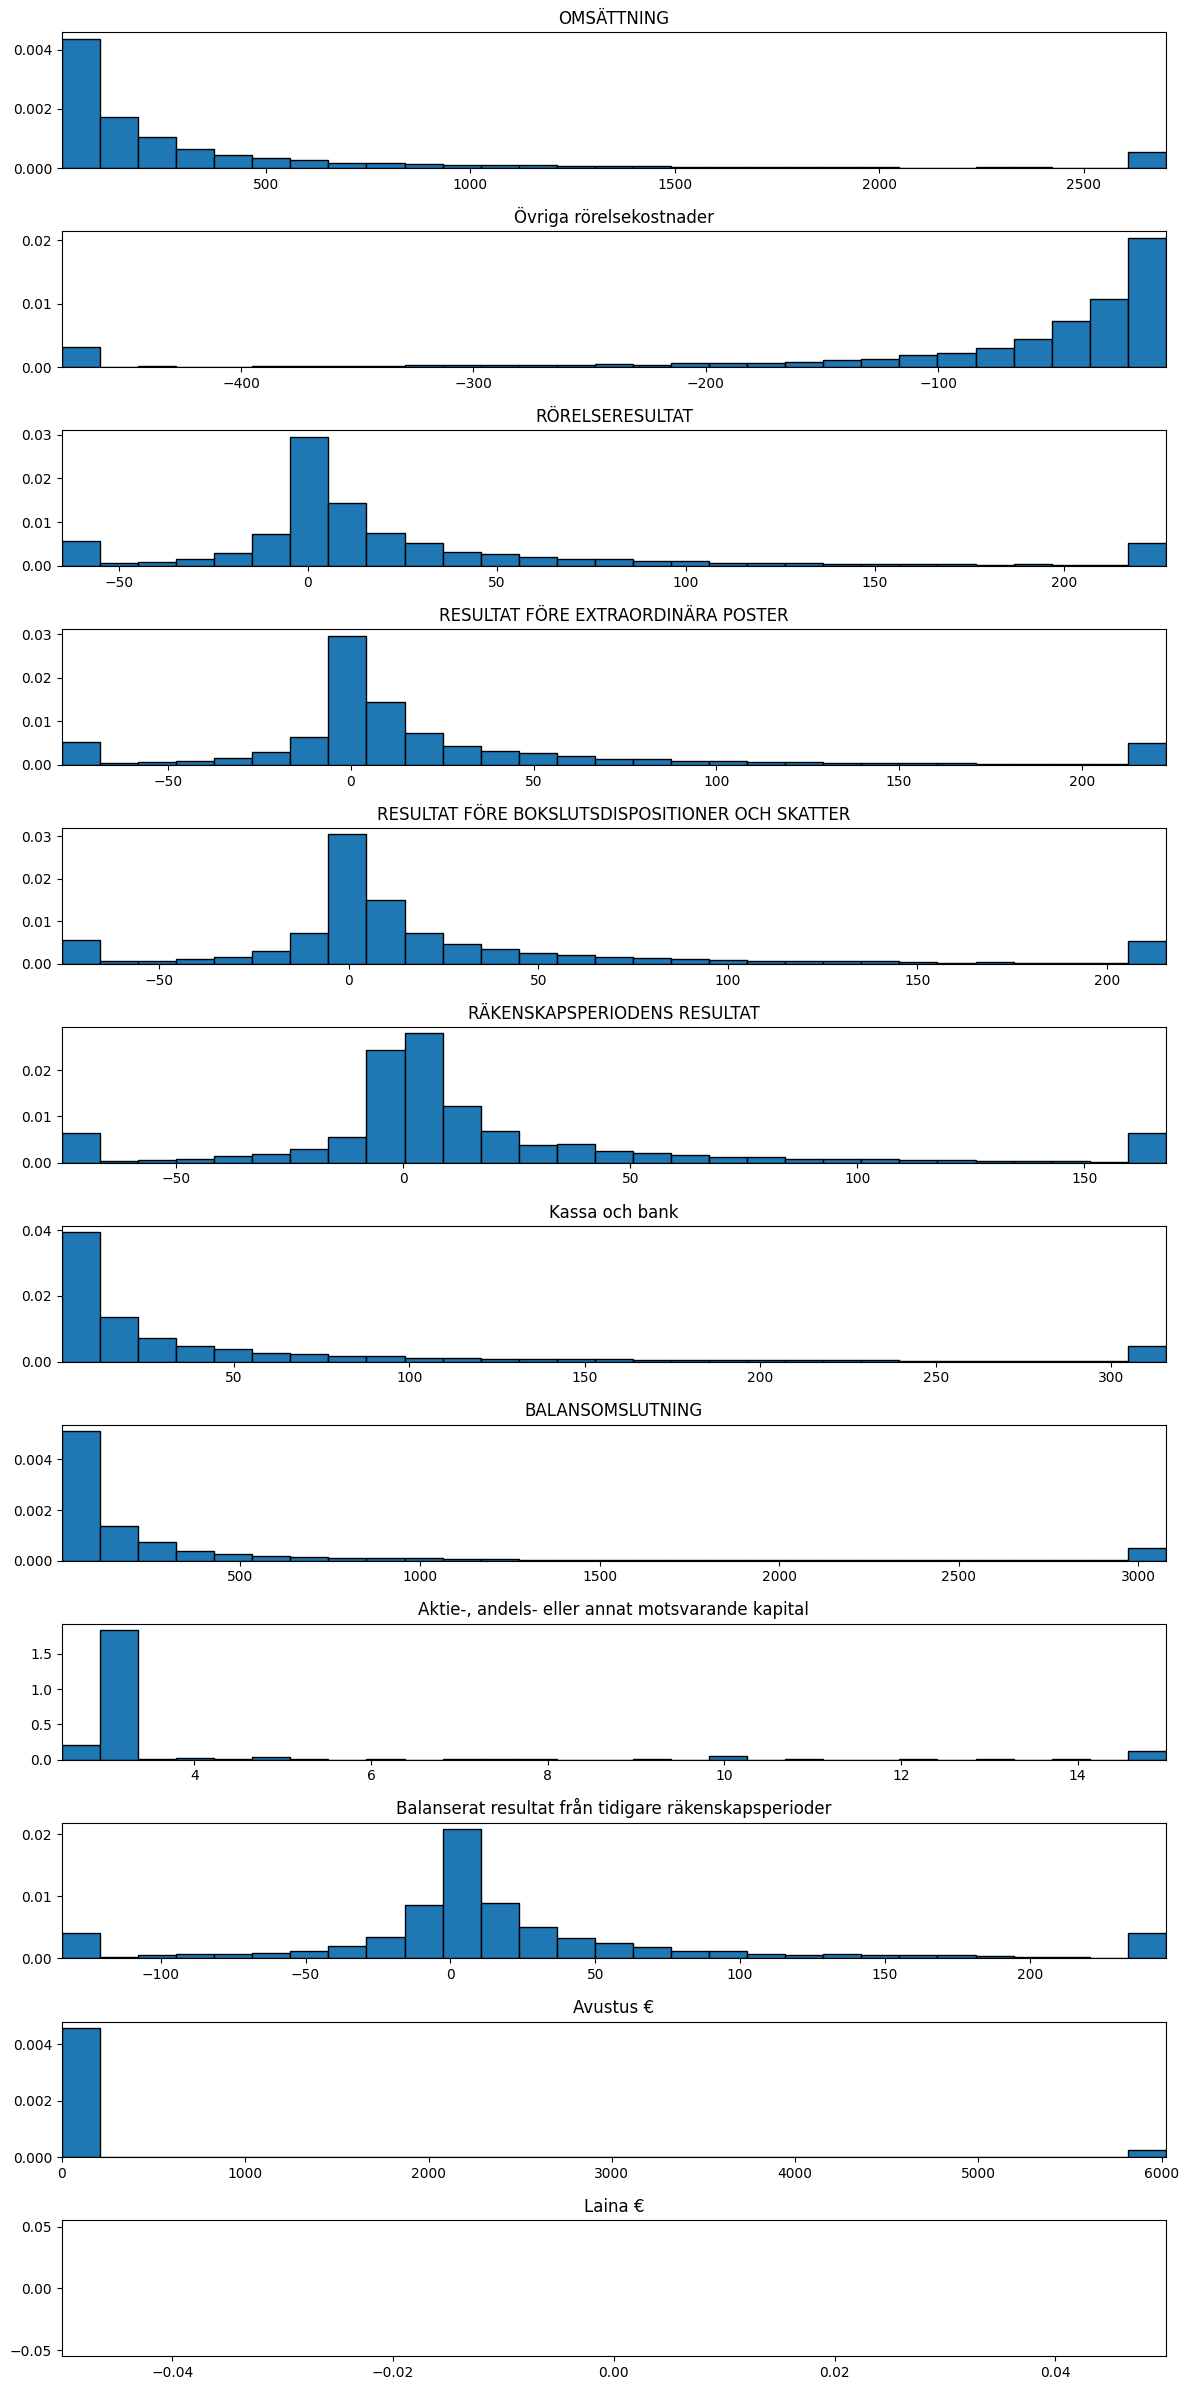

/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/Dropbox/Hanken/2024Linz/Bayes/coursework/utils/betaplots.py:58: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(q10, q90)


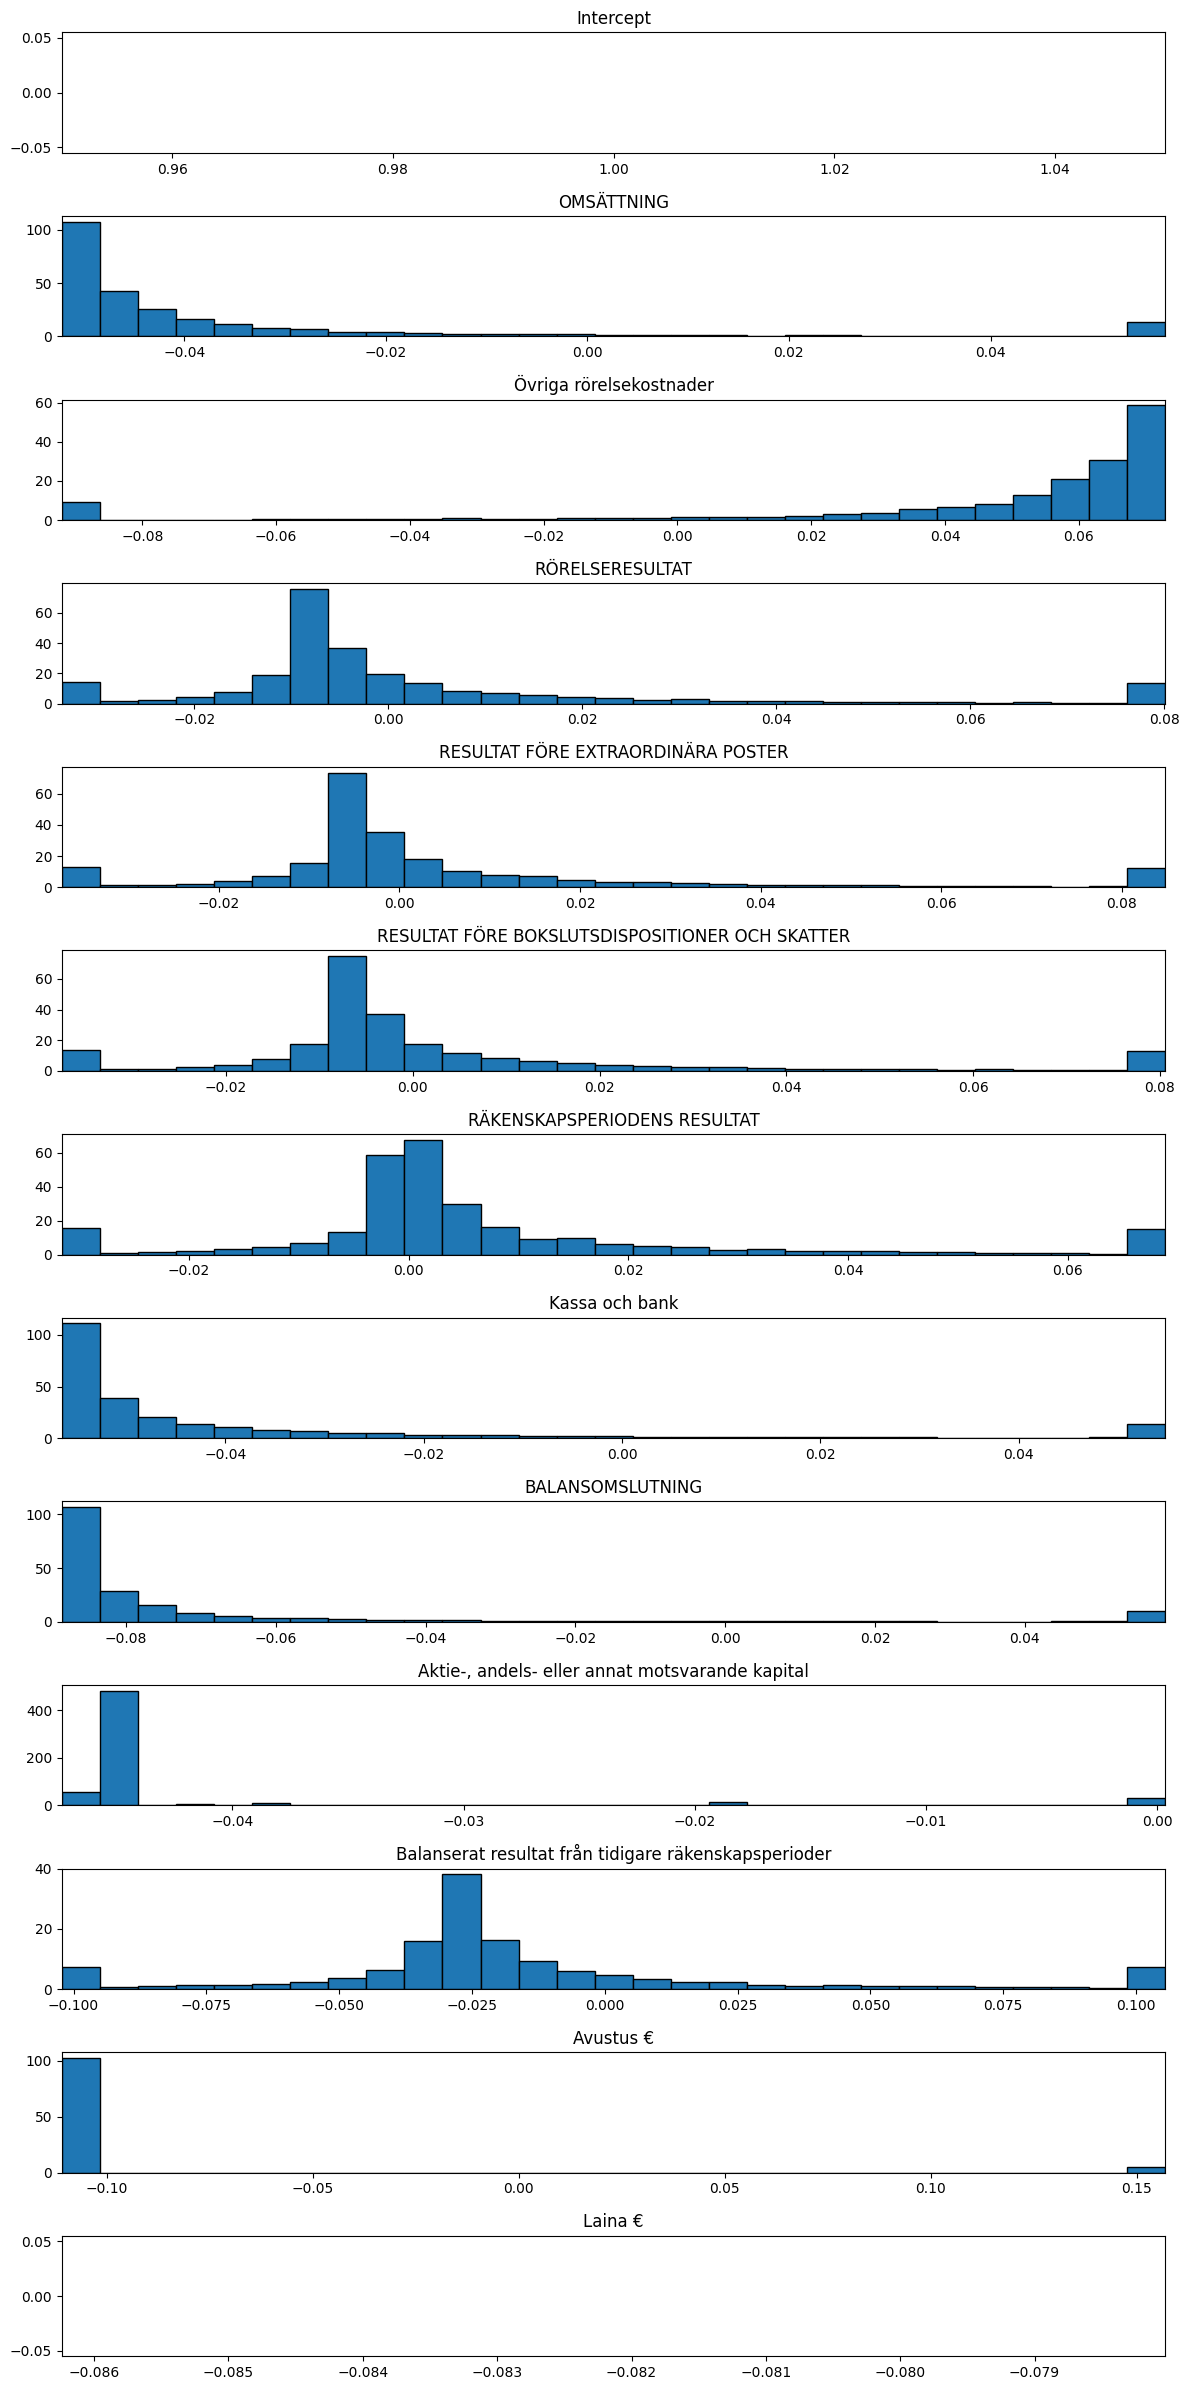

scale beta 1e-12
scale x 1e-12
iter 0 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_39745/2791631258.py:30: RuntimeWarning: invalid value encountered in sqrt
  std_j = np.sqrt(Sigma[j, j] - Sigma[j, :] @ np.linalg.inv(Sigma) @ Sigma[:, j])


iter 1 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 2 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 3 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 4 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 5 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 6 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 7 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 8 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 9 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 10 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 11 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 12 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 13 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 14 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 15 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 16 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 17 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 18 beta [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
iter 19 beta [0. 0. 0. 0. 0. 0. 0. 0.

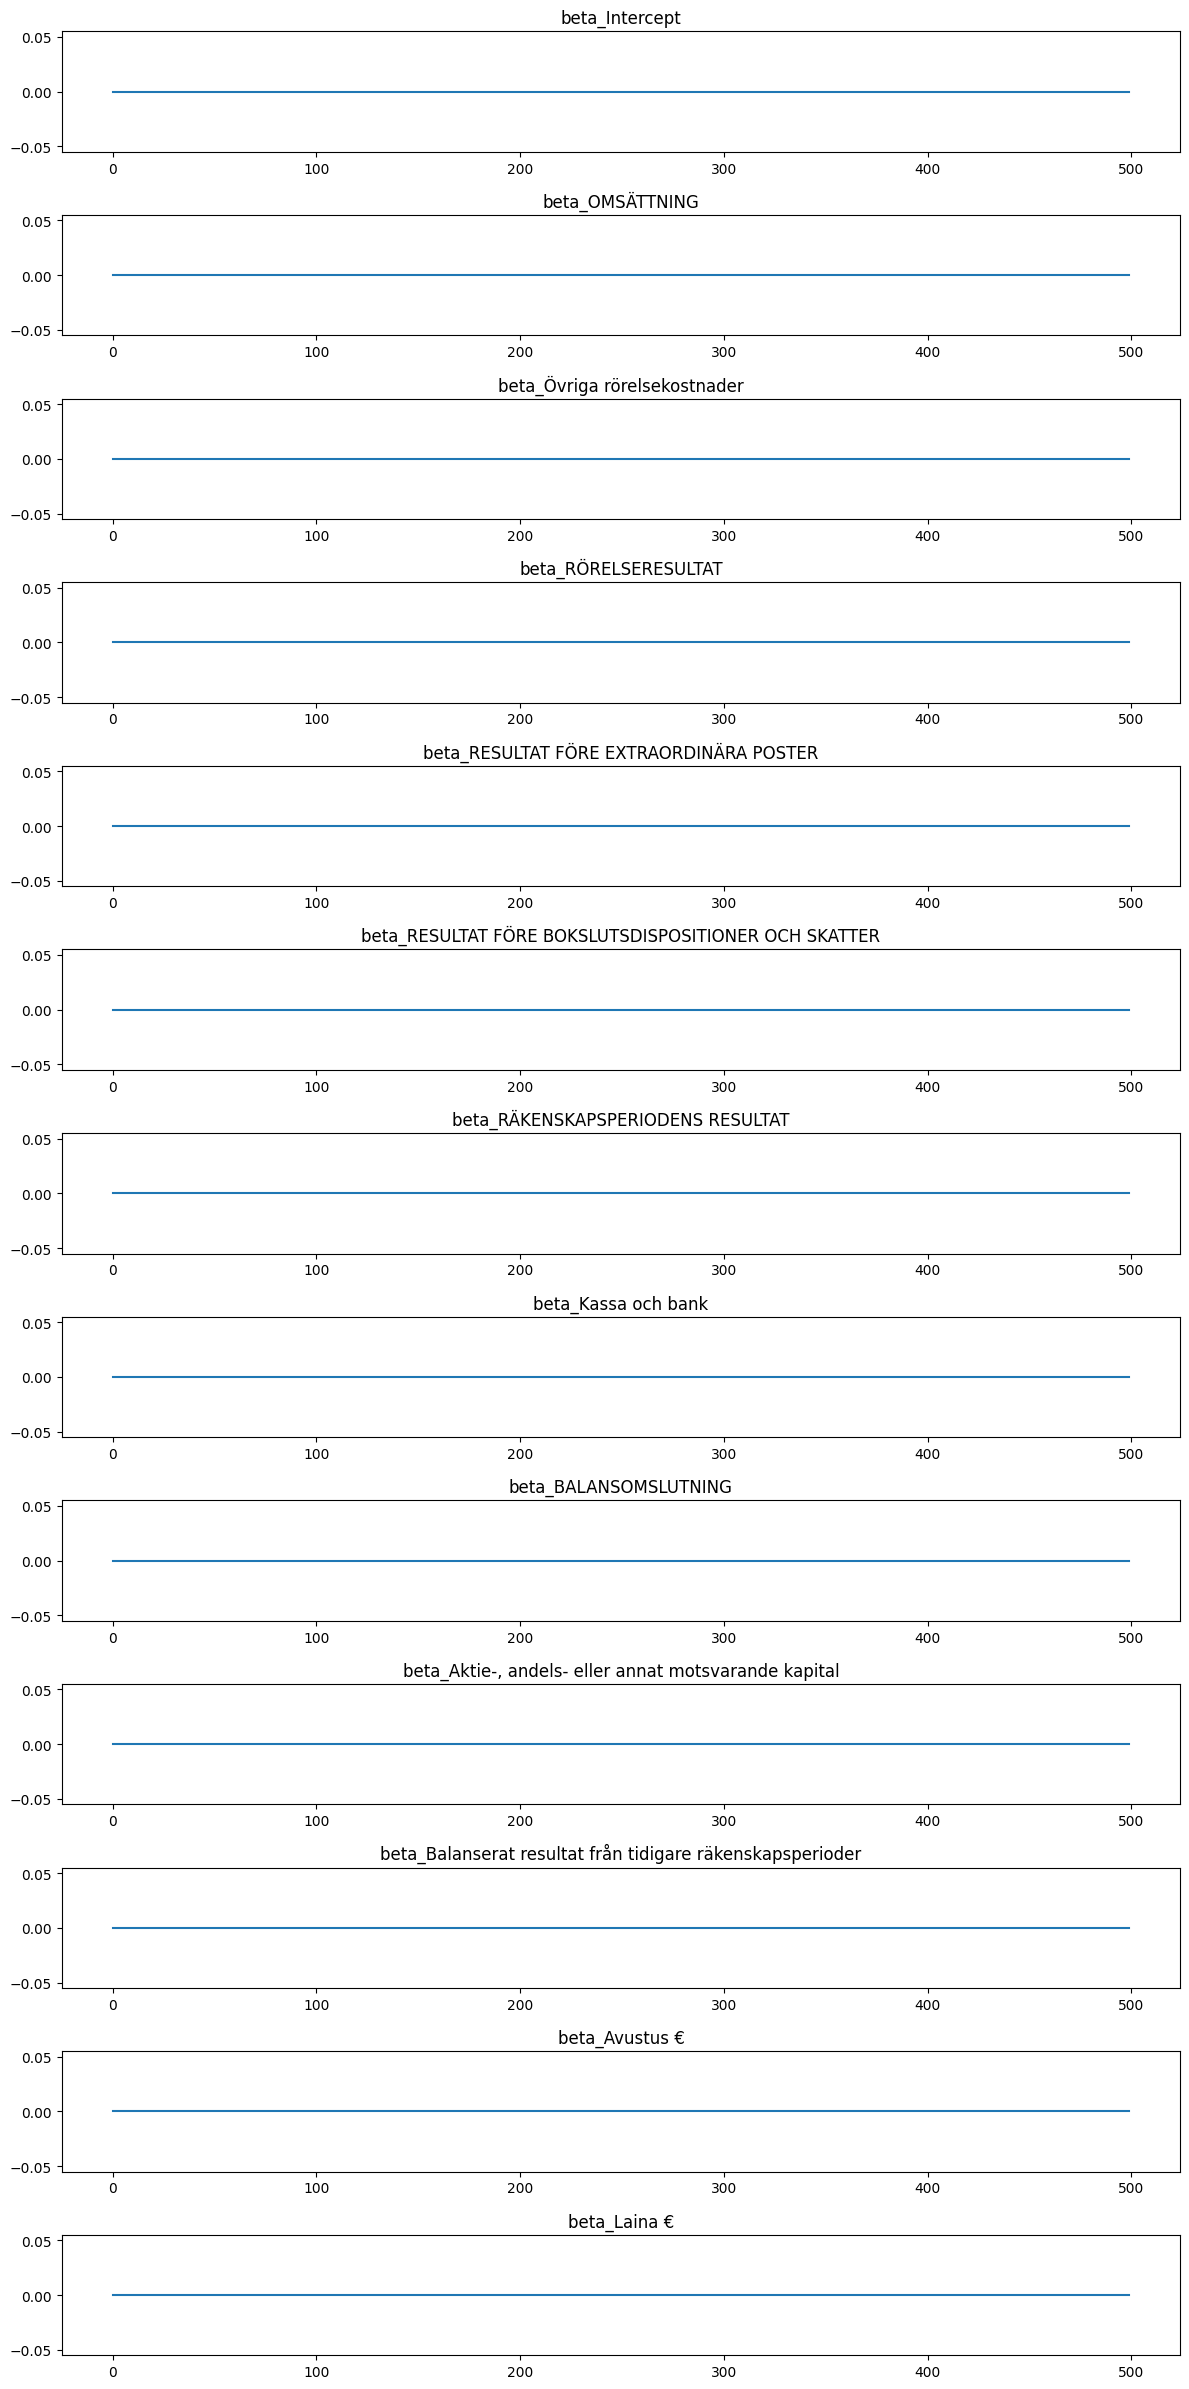

/home/markus/venvs/kandi/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Acceptance Rate: 0.0


/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/venvs/kandi/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/markus/Dropbox/Hanken/2024Linz/Bayes/coursework/utils/betaplots.py:58: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(q10, q90)


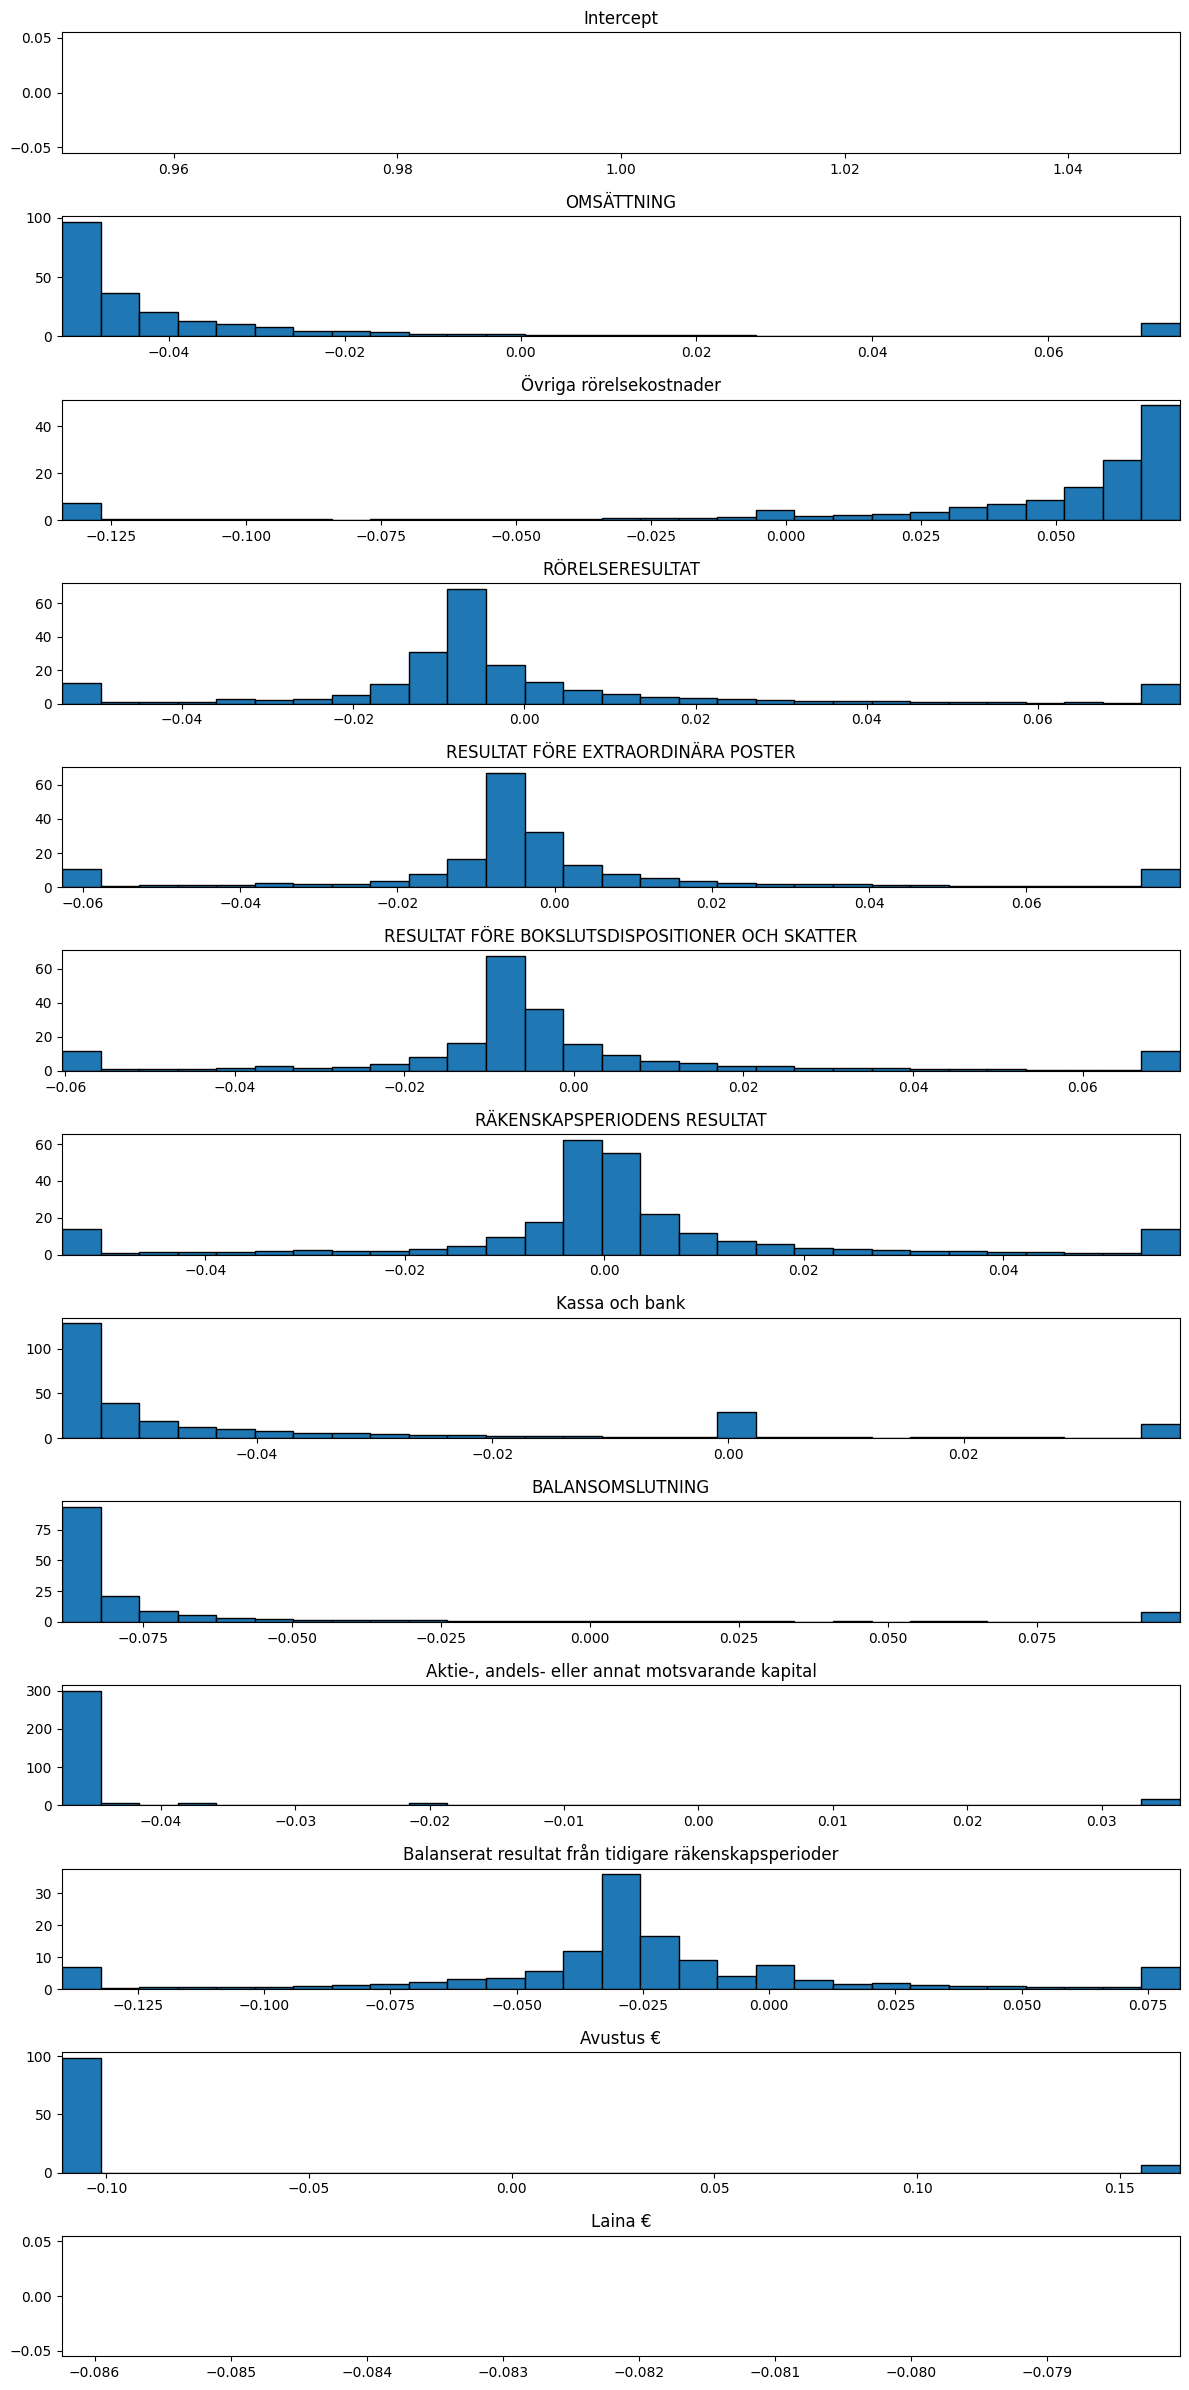

LinAlgError: Singular matrix

In [10]:
# 12 variables, 
main(burn=500, iter_tot=1000, scale_beta=1e-12, scale_x=1e-12,
     file_path=Path.home().joinpath("Dropbox/Hanken/2024Linz/Bayes/coursework/data/2018_data_filtered_minfrac_0.9_method_noInpute_withBB.csv"))
